In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft

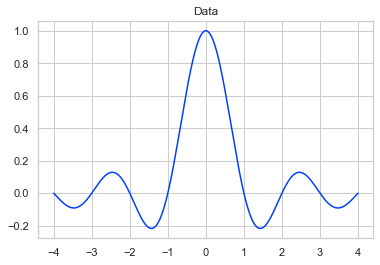

In [213]:
x = np.linspace(-4, 4, 500)
y = np.sinc(x)
plt.title('Data')
plt.plot(x,y)

In [214]:
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# GMM on actual time series

In [215]:
dfx = signal_3
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [256]:
print(best_gmm, '\n')
print('WEIGHTS -', best_gmm.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm.means_, '\n')

GaussianMixture(n_components=6) 

WEIGHTS - [0.168008   0.20725916 0.17639633 0.2037512  0.12630651 0.1182788 ] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 6.88839814e-01  3.90673277e-01]
 [-3.17589344e+00 -8.11067023e-04]
 [-6.91448980e-01  3.88525304e-01]
 [ 3.18916084e+00 -3.00909585e-03]
 [ 1.87199928e+00 -6.09881175e-02]
 [-1.87497336e+00 -6.07040450e-02]] 



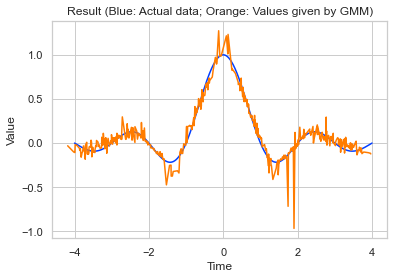

In [245]:
z,_ = best_gmm.sample(500)
plt.title('Result (Blue: Actual data; Orange: Values given by GMM)')
sns.lineplot(signal_3['Time'], signal_3['Value'])
sns.lineplot(z[:,0],z[:,1])
plt.show()

# GMM on FFT of actual time series

In [218]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_real,freq_ampli_img
freq_ampli3,freq_ampli3i = freq(signal_3)

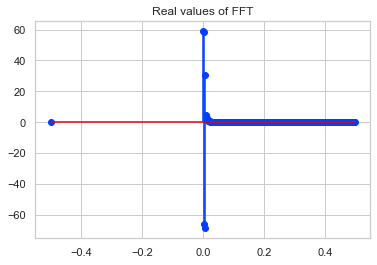

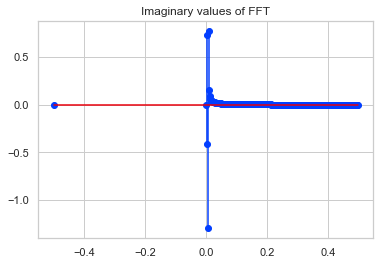

In [219]:
plt.stem(freq_ampli3['Freq'], freq_ampli3['Ampli'])
plt.title('Real values of FFT')
plt.show()
plt.stem(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [220]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [221]:
best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [253]:
print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')

GaussianMixture(n_components=6) 

WEIGHTS - [0.74205059 0.00796813 0.00796813 0.00398406 0.00398406 0.23404502] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 3.12685773e-01  2.07605780e-03]
 [ 4.00000000e-03 -6.72666470e+01]
 [ 2.00000000e-03  5.87731300e+01]
 [ 8.00000000e-03  3.08901088e+01]
 [ 1.00000000e-02  4.87691751e+00]
 [ 5.92524916e-02  1.78055081e-01]] 



In [255]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=6) 

WEIGHTS - [0.02825897 0.65836104 0.22375722 0.00398406 0.00796813 0.07767058] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[-0.0623037  -0.0068453 ]
 [ 0.33300545  0.00133437]
 [ 0.11446403  0.00597537]
 [ 0.006      -1.2977939 ]
 [ 0.006       0.7545441 ]
 [ 0.03675641  0.02096346]] 



In [224]:
#Sampling
z1,_ = best_gmm0.sample(251)
z1i,_ = best_gmm0i.sample(251)

In [225]:
sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [226]:
sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [227]:
f = fftpack.fftfreq(500)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [228]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [229]:
sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [230]:
samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [231]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

{0.0: 0.0,
 0.002: 0.0,
 0.004: -67.10641499276242,
 0.006: -69.57807669476142,
 0.008: 30.890007531161412,
 0.01: -0.005811901244006018,
 0.012: 4.875827169120869,
 0.014: 0.0,
 0.016: 0.009245120160049195,
 0.018: 0.0,
 0.02: 0.5702395416426982,
 0.022: 0.0,
 0.024: 0.29139168459216397,
 0.026: 0.0,
 0.028: 0.0,
 0.03: 0.0,
 0.032: -0.03966822500801903,
 0.034: 0.0,
 0.036: 0.0,
 0.038: 0.0,
 0.04: -0.11428009761994734,
 0.042: 0.0,
 0.044: 0.0,
 0.046: 0.1656043394507317,
 0.048: -0.2471605381463392,
 0.05: 0.8604692557190128,
 0.052: 0.0,
 0.054: -0.4145297891893103,
 0.056: 0.006368188276927785,
 0.058: 0.13573470887972686,
 0.06: 0.0,
 0.062: -0.37544889844250146,
 0.064: 0.0,
 0.066: 0.00636337350187992,
 0.068: 0.650042916262539,
 0.07: 0.5262148507920279,
 0.072: 0.009305932954971017,
 0.074: 0.0,
 0.076: 0.0,
 0.078: 0.0,
 0.08: -0.2657624175196504,
 0.082: 0.4653621178314819,
 0.084: 0.0,
 0.086: 0.0,
 0.088: 0.0,
 0.09: 0.0,
 0.092: 0.0,
 0.094: 0.31593454074325056,
 0.096:

In [232]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.002: 0.7063417768520337j,
 0.004: (-67.10641499276242+0.7267930272110077j),
 0.006: (-69.57807669476142+0.7387055691409377j),
 0.008: (30.890007531161412+1.5028953306256796j),
 0.01: -0.005811901244006018,
 0.012: 4.875827169120869,
 0.014: 0.0,
 0.016: 0.009245120160049195,
 0.018: 0.03216541433757058j,
 0.02: 0.5702395416426982,
 0.022: 0.0,
 0.024: (0.29139168459216397+0.03251419636089269j),
 0.026: 0.026483809928200243j,
 0.028: 0.026776890977146615j,
 0.03: 0.0,
 0.032: (-0.03966822500801903+0.0488932153988338j),
 0.034: 0.07913176643434601j,
 0.036: 0.009161987738750842j,
 0.038: 0.0,
 0.04: (-0.11428009761994734+0.03947403896762233j),
 0.042: 0.0,
 0.044: 0.01913256038149499j,
 0.046: (0.1656043394507317+0.008127265212372892j),
 0.048: (-0.2471605381463392+0.009399708193049087j),
 0.05: (0.8604692557190128+0.009801833897733685j),
 0.052: 0.018137467946302815j,
 0.054: (-0.4145297891893103+0.008269913576493659j),
 0.056: (0.006368188276927785+0.003552916240787154j),

In [233]:
value = list(sd.values())

# Final IFFT 

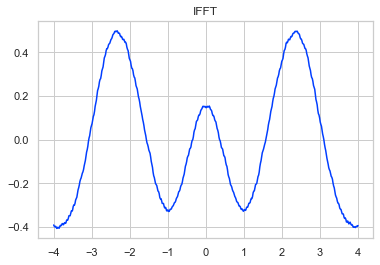

In [234]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(x,ift)